## Data analysis for anomaly

In [1]:
import dask
import numpy as np
import pandas as pd
import dask.dataframe as dd
import math
from dask.distributed import Client
#Importing plot lib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
sns.set(rc={'figure.figsize':(20, 10)})
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from math import sqrt
import warnings;
warnings.filterwarnings('ignore');
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':200})
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [2]:
data_win = dd.read_csv('data_win.csv').compute()
data_win.head()

,te,pkt,byt,label
0,2016-06-01 00:05:00,9137379,5169739889,0
1,2016-06-01 00:10:00,12126441,8373608719,0
2,2016-06-01 00:15:00,13050846,9565382340,0
3,2016-06-01 00:20:00,11543577,8782554929,0
4,2016-06-01 00:25:00,11745197,8282543104,0


In [3]:
data_normal_traffic_win = dd.read_csv('data_normal_traffic_win.csv').compute()
data_normal_traffic_win.head()

,te,pkt,byt
0,2016-06-01 00:05:00,9137379,5169739889
1,2016-06-01 00:10:00,12126441,8373608719
2,2016-06-01 00:15:00,13050846,9565382340
3,2016-06-01 00:20:00,11543577,8782554929
4,2016-06-01 00:25:00,11745197,8282543104


In [4]:
test_data_normal_traffic_win = dd.read_csv('test_data_normal_traffic_win.csv').compute()
test_data_normal_traffic_win.head()

,te,pkt,byt
0,2016-06-20 00:05:00,4678691,3216020051
1,2016-06-20 00:10:00,10912169,8318748638
2,2016-06-20 00:15:00,9991484,7257315772
3,2016-06-20 00:20:00,11717672,8485465746
4,2016-06-20 00:25:00,10170520,7872342903


In [5]:
test_data_win = dd.read_csv('test_data_win.csv').compute()
test_data_win.head(10)

,te,pkt,byt,label
0,2016-06-20 00:05:00,4678691,3216020051,0
1,2016-06-20 00:10:00,10912169,8318748638,0
2,2016-06-20 00:15:00,9991484,7257315772,0
3,2016-06-20 00:20:00,11717672,8485465746,0
4,2016-06-20 00:25:00,10170520,7872342903,0
5,2016-06-20 00:30:00,10105649,7638145388,0
6,2016-06-20 00:35:00,9823901,7305766930,0
7,2016-06-20 00:40:00,9275407,6909553722,0
8,2016-06-20 00:45:00,9228637,6909369247,0
9,2016-06-20 00:50:00,8767190,6403418333,0


### Let us check how anomaly point are placed with data distribution

In [6]:
mean_byt = data_normal_traffic_win.byt.mean()

In [48]:
#30 min window
window = 5

In [49]:
mean_series = data_normal_traffic_win.byt.rolling(window=window).mean()

In [50]:
mean_series.fillna(0)

0       0.000000e+00
1       0.000000e+00
2       0.000000e+00
3       0.000000e+00
4       8.034766e+09
            ...     
5468    7.234697e+09
5469    7.855243e+09
5470    7.877074e+09
5471    7.866575e+09
5472    7.044007e+09
Name: byt, Length: 5473, dtype: float64

In [61]:
data_win_anomaly = data_win[data_win['label'] == 1].label
data_win_anomaly.head()

7      1
77     1
228    1
237    1
326    1
Name: label, dtype: int64

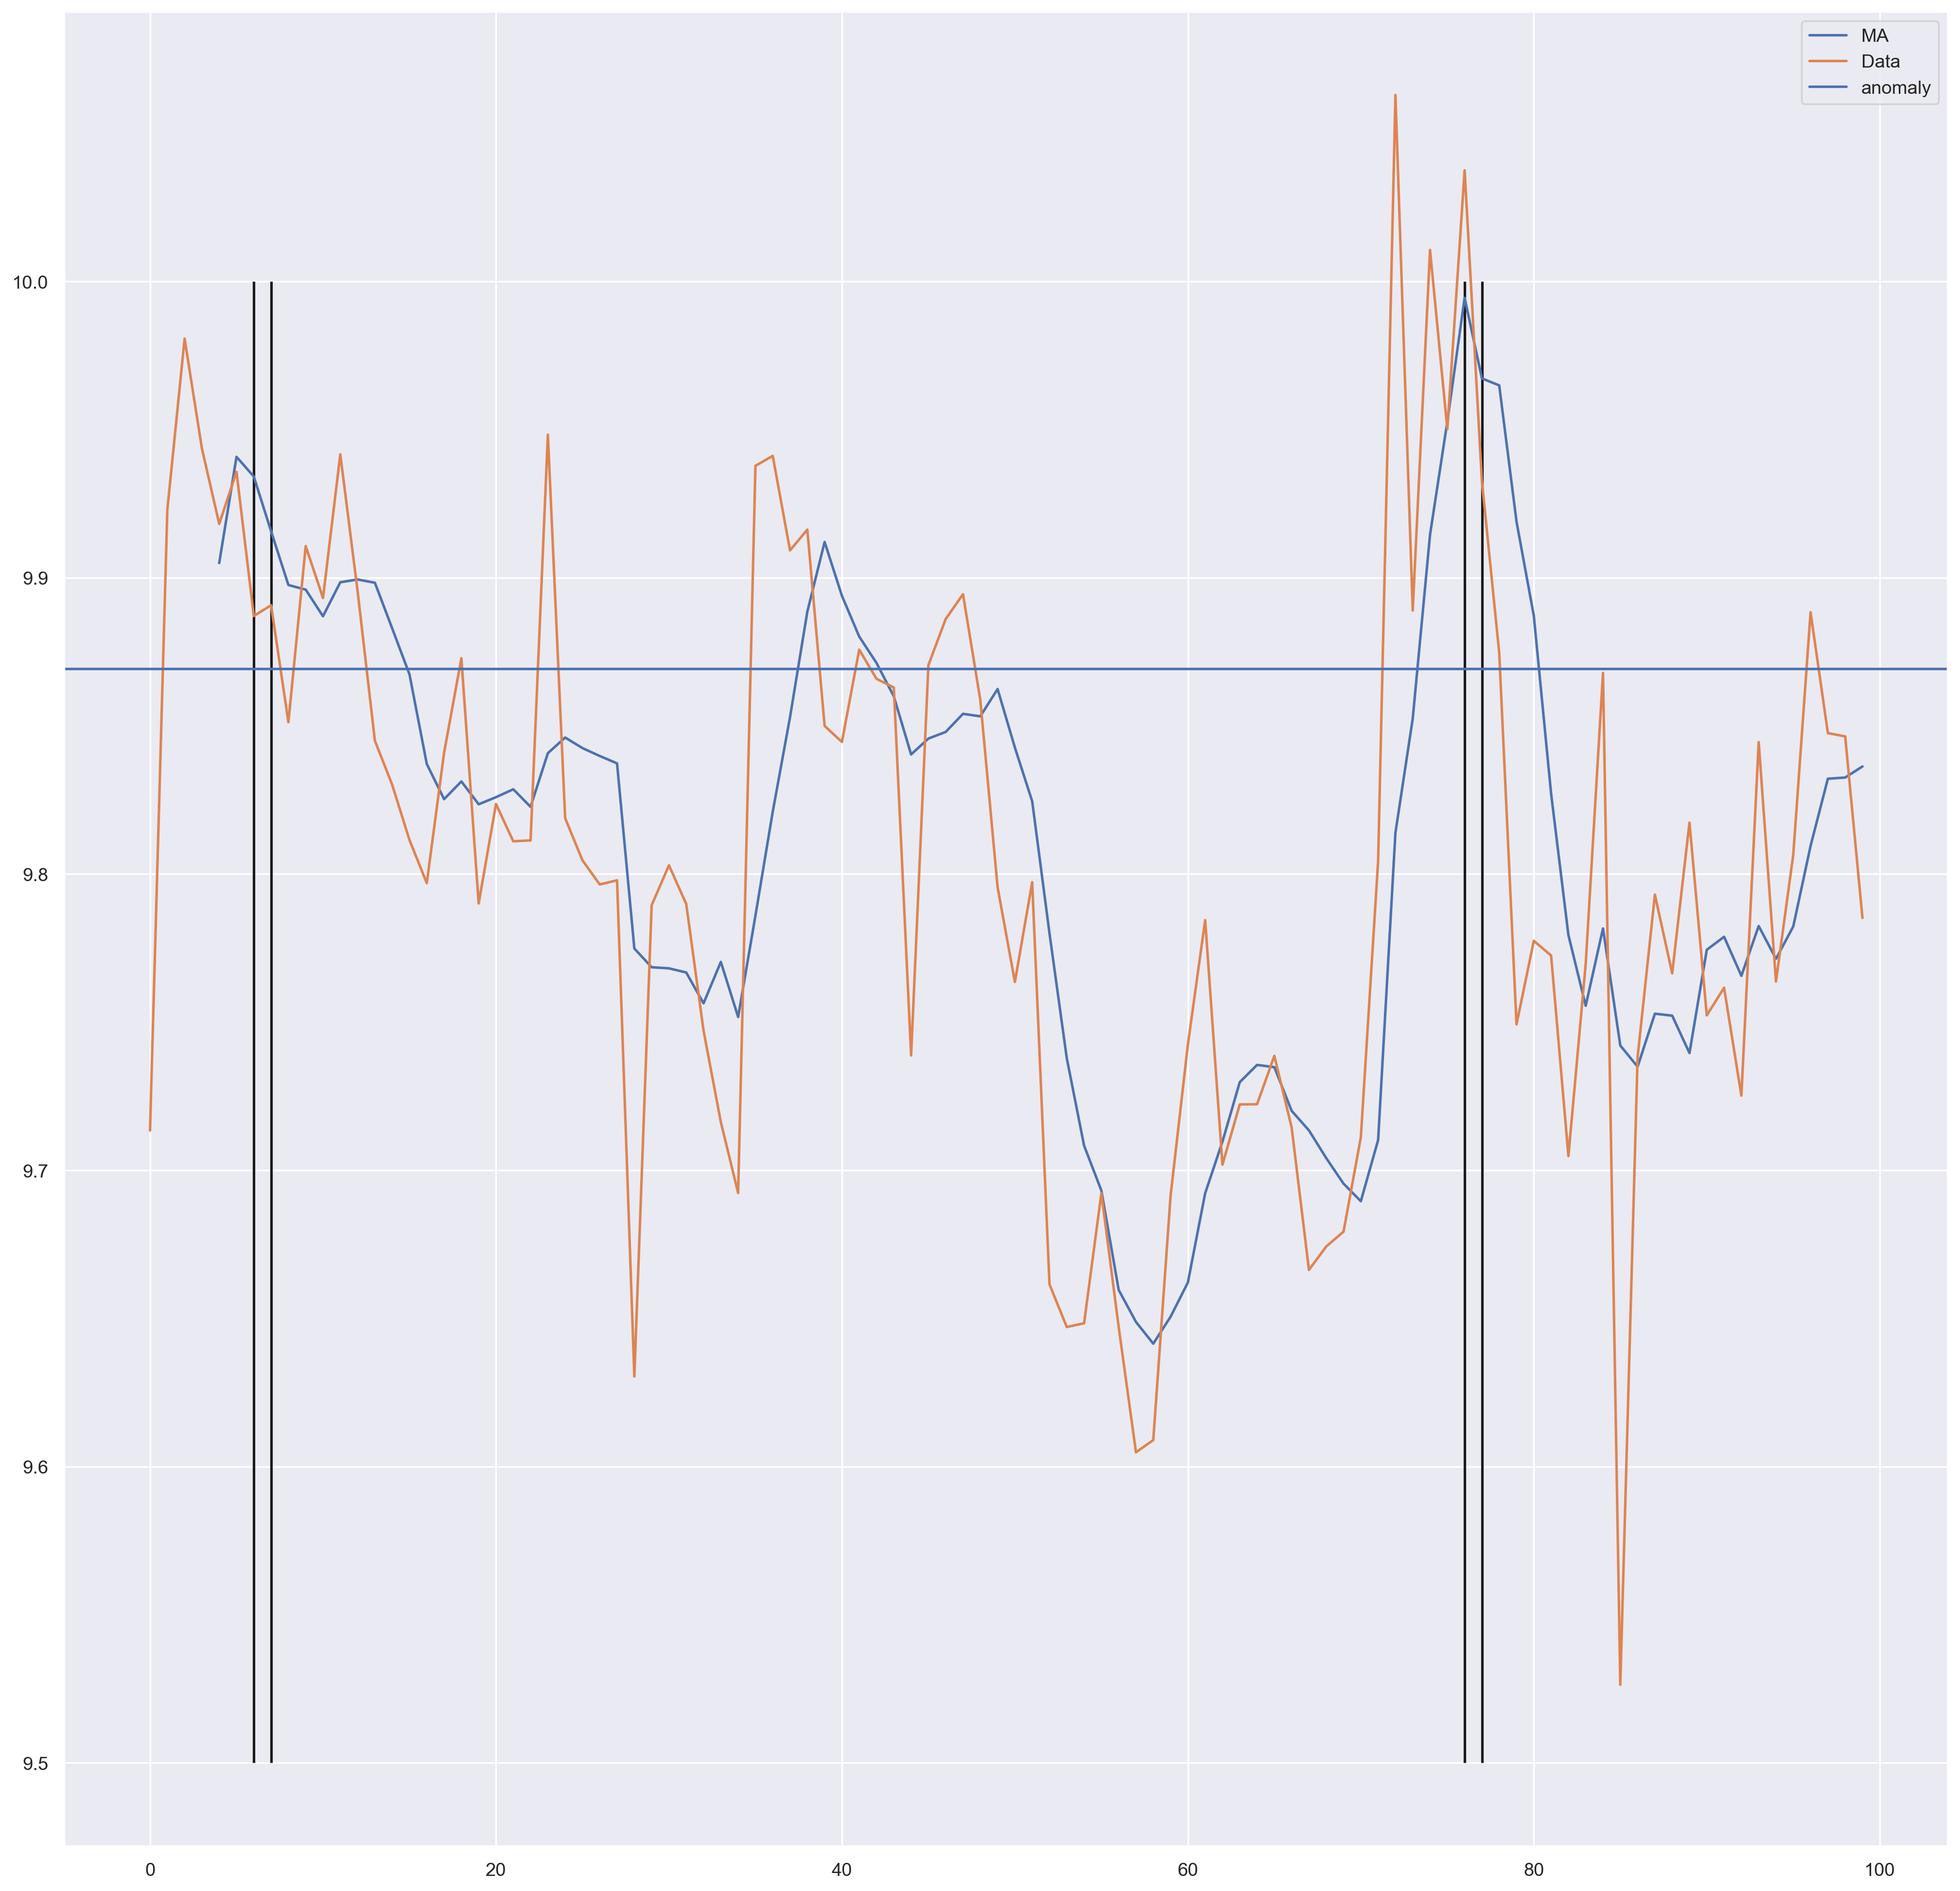

In [89]:
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':250})
plt.plot(np.log10(mean_series[:100]))
plt.plot(np.log10(data_win.byt[:100]))
plt.vlines(data_win_anomaly.index[:2], ymax=10, ymin=9.5)
plt.vlines(data_win_anomaly.index[:2] -1, ymax=10, ymin=9.5)
plt.axhline(np.log10(mean_byt))

plt.legend(["MA", "Data", "anomaly"])
plt.show()
plt.close()

In [103]:
data_diff = pd.DataFrame()
data_diff['mean'] = mean_series[data_win_anomaly.index]
data_diff['actual'] = data_win.byt[data_win_anomaly.index]
data_diff.reset_index(drop=True, inplace=True)

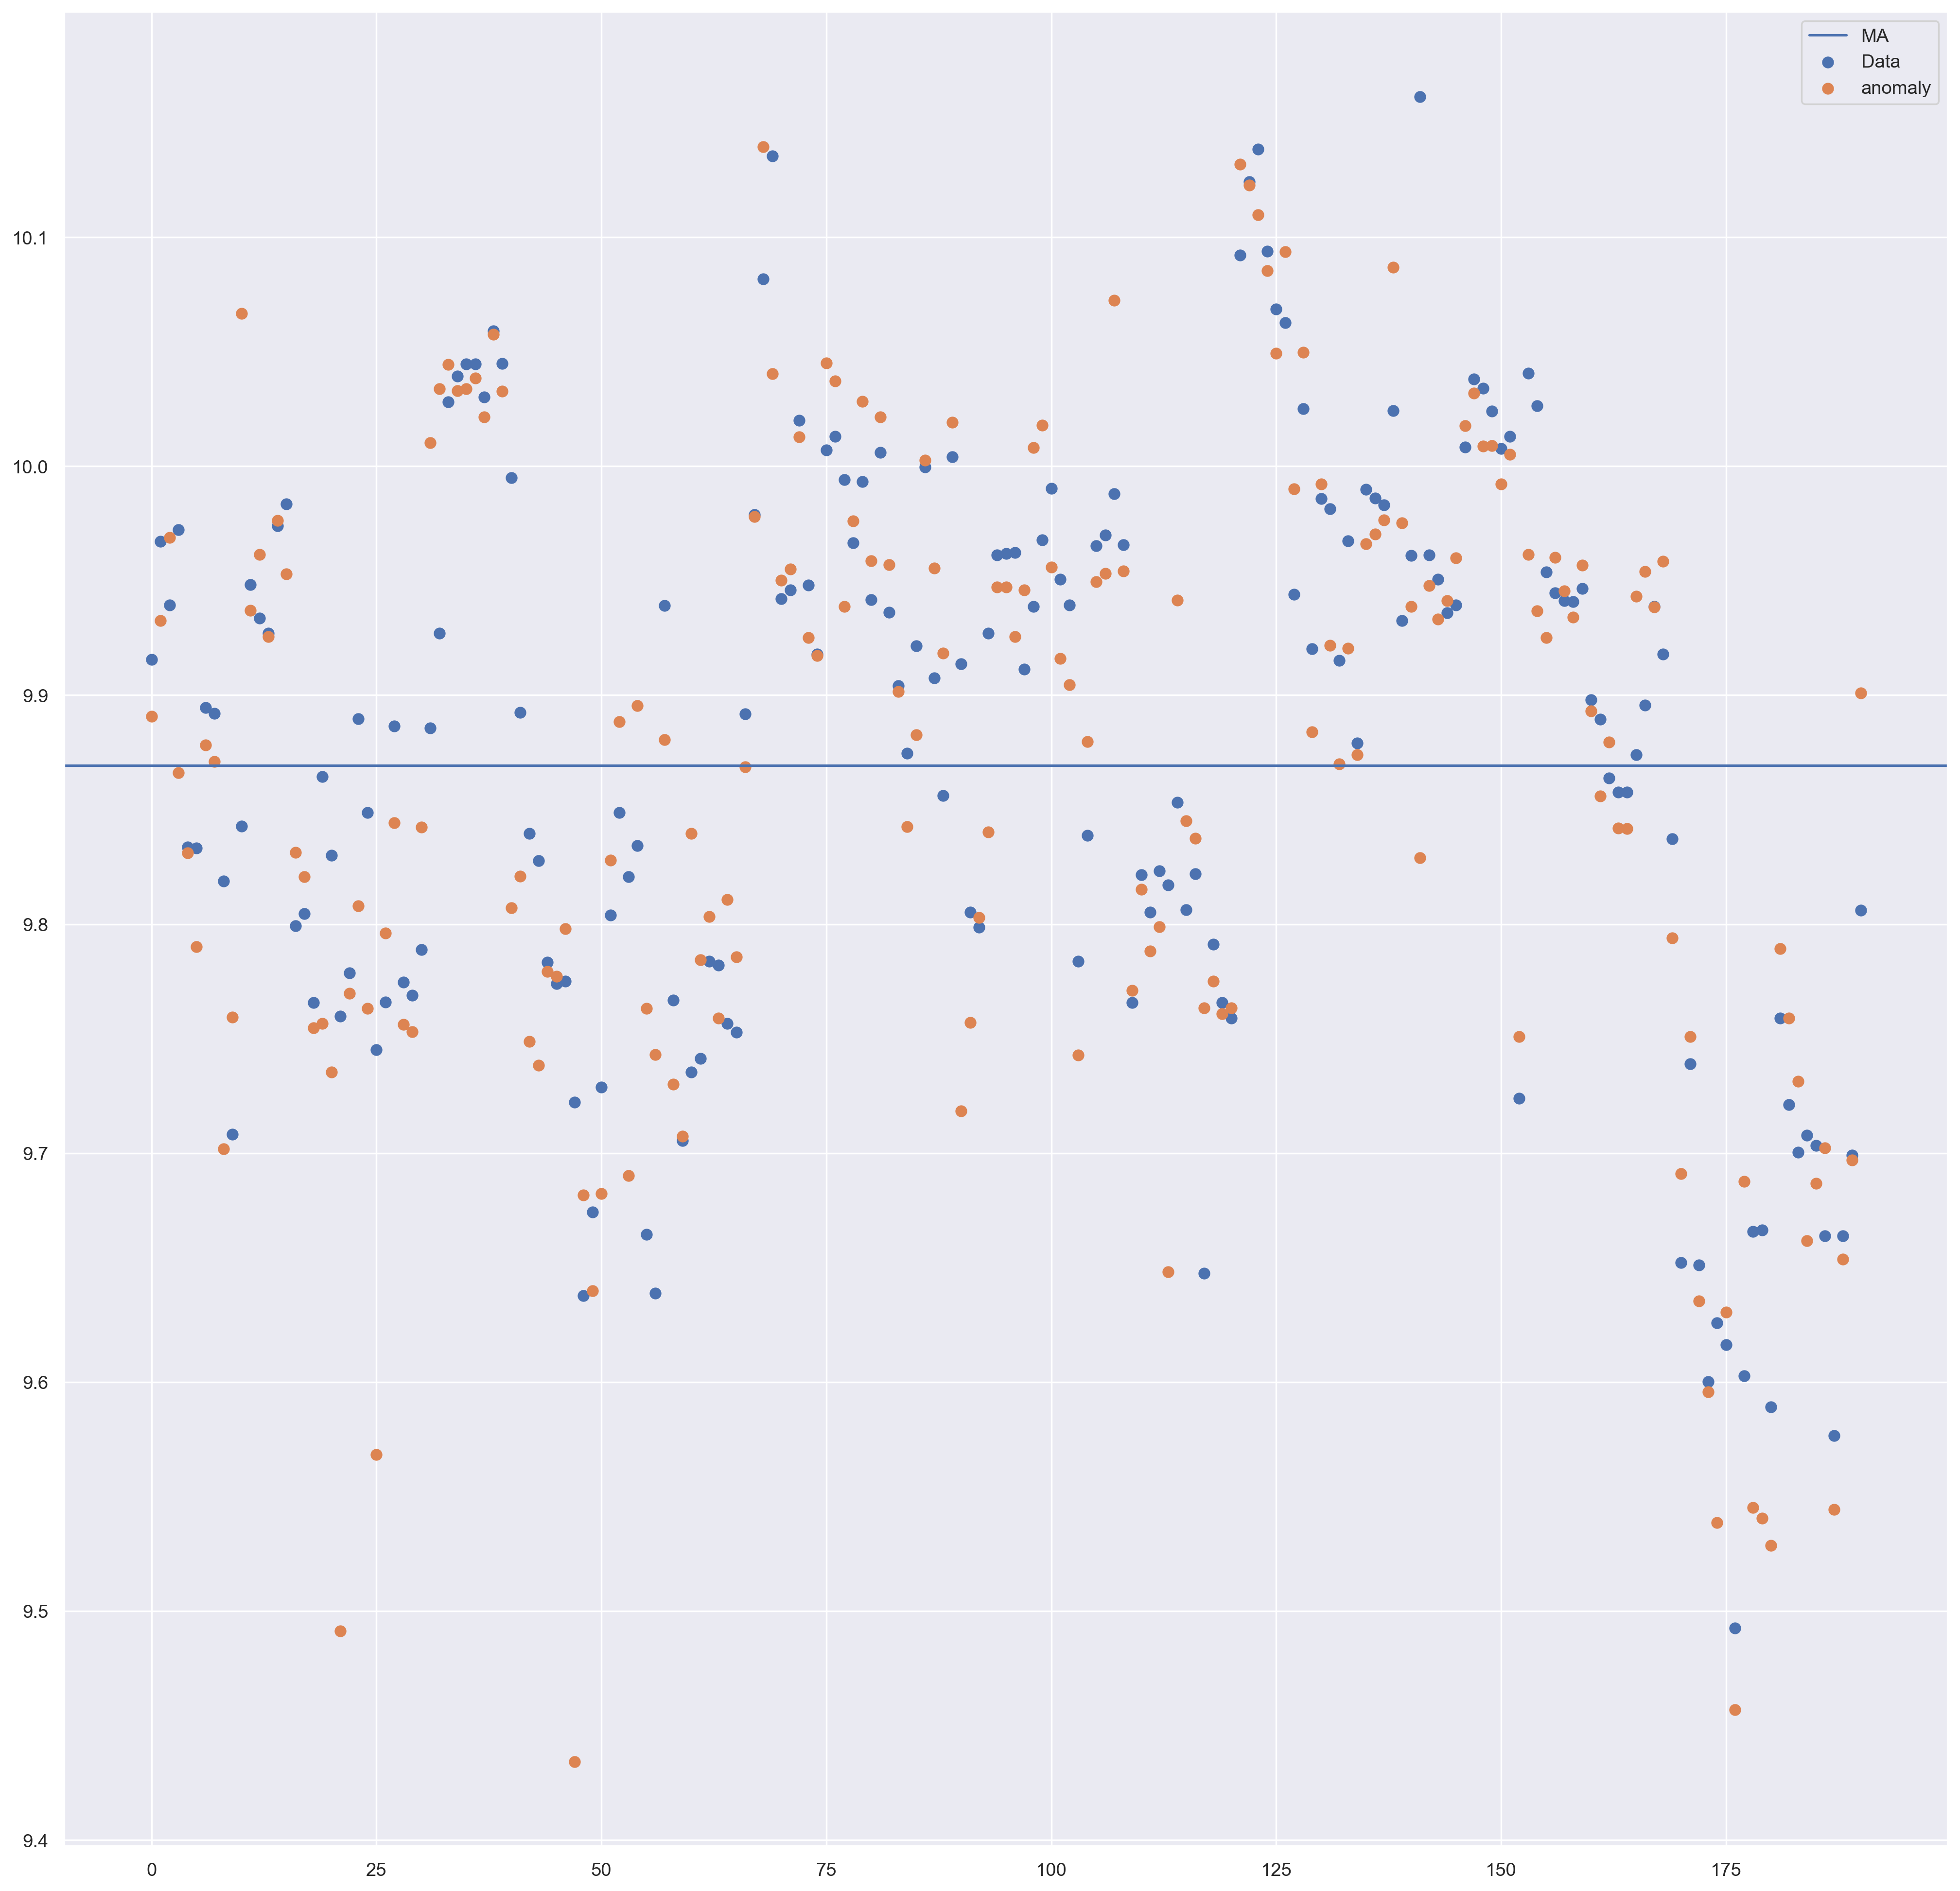

In [106]:
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':250})
plt.scatter(np.arange(len(data_diff)),np.log10(data_diff['mean']))
plt.scatter(np.arange(len(data_diff)),np.log10(data_diff['actual']))
plt.axhline(np.log10(mean_byt))

plt.legend(["MA", "Data", "anomaly"])
plt.show()
plt.close()